---
title: "SWD Properties"
---

## Setup

In [22]:
#| hide
import polars as pl
import polars.selectors as cs

from ids_finder.utils.basic import load_catalog

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
catalog = load_catalog()

Connect `python` with `R` kernel

In [24]:
%load_ext rpy2.ipython
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

 Found  1  deps for  0/1  pkgs [⠋] Resolving standard (CRAN/BioC) packages
 
ℹ No downloads are needed

Installing...
✔ 1 pkg + 77 deps: kept 66 s]


## Processing datasets

In [25]:
all_events_l1 : pl.DataFrame = catalog.load('events.l1.ALL_sw_ts_1s_tau_60s').collect()
JUNO_events_l1 : pl.LazyFrame = catalog.load('events.l1.JNO_ts_1s_tau_60s').collect()

%R -i all_events_l1 -c conv_pl

[11/20/23 21:24:24] INFO     Loading data from 'events.l1.ALL_sw_ts_1s_tau_60s'                 ]8;id=432352;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=672130;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'events.l1.JNO_ts_1s_tau_60s'                    ]8;id=905833;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=261312;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

Some extreme values are present in the data. We will remove them.

In [26]:
NVARS = ['d_star', 'L_mn', 'L_mn_norm', 'j0', 'j0_norm', 'duration', 'v_mn']
DISPLAY_VARS = ['time', 'sat'] + NVARS


def check_candidates(df):
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    return df.select(NVARS).describe()

check_candidates(all_events_l1)

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",165643.0,165643.0,165643.0,165643.0,165643.0,"""165643""",165643.0
"""null_count""",0.0,0.0,242.0,0.0,242.0,"""0""",0.0
"""mean""",0.746723,2666.378873,21.221608,1.875768,0.075945,"""0:00:07.848783…",342.551648
"""std""",0.770639,1710.476049,16.145719,2.562655,0.094997,null,99.310305
"""min""",0.019601,53.009354,0.227812,0.0561,0.00082,"""0:00:01.999999…",10.240242
"""25%""",0.246728,1563.011024,11.081883,0.610077,0.028741,"""0:00:05""",285.457921
"""50%""",0.506755,2197.427503,17.07352,1.249547,0.052072,"""0:00:06.999999…",342.001899
"""75%""",0.97093,3244.601925,26.357584,2.358149,0.092691,"""0:00:09""",400.161627
"""max""",13.805873,25057.028812,373.127461,393.479096,9.634978,"""0:00:55""",864.604665


In [27]:
jno_candidates_l1 = all_events_l1.filter(pl.col('sat') == 'JNO')
%R -i jno_candidates_l1 -c conv_pl

In [28]:
from ids_finder.pipelines.project.pipeline import process_events_l2

In [29]:
all_events_l2 = all_events_l1.pipe(process_events_l2)

In [30]:
inspect_df = all_events_l2[NVARS]
inspect_df.describe()

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",173.0,173.0,173.0,173.0,173.0,"""173""",173.0
"""null_count""",19.0,19.0,19.0,19.0,19.0,"""19""",19.0
"""mean""",0.717987,2794.839887,21.166249,1.970931,0.091238,"""0:00:08.331127…",337.337424
"""std""",0.364196,474.342591,7.603784,1.099687,0.05106,null,38.047279
"""min""",0.110302,1850.648336,6.878194,0.233657,0.031348,"""0:00:06.486081…",257.192572
"""25%""",0.33728,2472.720243,14.005139,0.809712,0.06047,"""0:00:07.494646…",313.746558
"""50%""",0.802389,2694.279555,22.505979,2.105665,0.070916,"""0:00:08.323287…",334.70826
"""75%""",0.941456,3024.504077,26.456635,2.66893,0.095718,"""0:00:08.801112…",359.814987
"""max""",1.563245,4231.415645,38.19885,4.875562,0.298382,"""0:00:11.537142…",444.353823


## Orientation

In [31]:
import hvplot.polars
import warnings

# Suppress specific FutureWarning from pandas in Holoviews
warnings.filterwarnings(
    "ignore", category=FutureWarning, module="holoviews.core.data.pandas"
)


def dist_plot(df: pl.LazyFrame, var, by="sat"):
    return df.hvplot.density(var, by=by, subplots=True, width=300, height=300).cols(1)

In [32]:
(
    dist_plot(all_events_l1, "k_x")
    + dist_plot(all_events_l1, "k_y")
    + dist_plot(all_events_l1, "k_z")
)

:Layout
   .NdLayout.I   :NdLayout   [sat]
      :Distribution   [k_x]   (Density)
   .NdLayout.II  :NdLayout   [sat]
      :Distribution   [k_y]   (Density)
   .NdLayout.III :NdLayout   [sat]
      :Distribution   [k_z]   (Density)

In [33]:
thresold = 0.2

def temp_plot(l1_df, y="j0_norm"):
    return l1_df.pipe(process_events_l2).hvplot(
        x="time", y=y, by="sat", hover_cols=["id_count"], width=300, height=300, legend=False
    )

direction_col = pl.col('k_x').abs()

((
    all_events_l1.pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="j0_norm")
) + (
    all_events_l1.pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="L_mn_norm")
)).cols(3)

:Layout
   .NdOverlay.I   :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.II  :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.III :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.IV  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.V   :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.VI  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)

## Plotting function

Plotting function for Level 1 data.

Similar to the `geom_bin2d` function, but with added functionality

- Normalize the data to every x-axis value
- Add peak values
- Add mean values with error bars

In [34]:
%%R
library(scales)
# Helper function to calculate summary statistics for x-binned data
calculate_summary <- function(data, x_col, y_col, x_seq) {
  data %>%
    mutate(!!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE)]) %>%
    group_by(!!sym(x_col)) %>%
    summarise(
      mean_y = mean(!!sym(y_col), na.rm = TRUE),
      sd_y = sd(!!sym(y_col), na.rm = TRUE),
      se_y = sd_y / sqrt(n())
    )
}


plot_binned_data <- function(data, x_col, y_col, x_bins, y_bins, y_lim=NULL, log_y=FALSE) {
  
  # If y_lim is provided, filter the data
  if (!is.null(y_lim)) {
    data <- data %>%
      filter(!!sym(y_col) >= y_lim[1], !!sym(y_col) <= y_lim[2])
  }
  
  # If transform_log_y is TRUE, transform y_col to log scale
  if (log_y) {
    data[[y_col]] <- log10(data[[y_col]])
    y_label <- paste("Log10", y_col)
  } else {
    y_label <- y_col
  }
  
  # Define bins for x and y based on the input parameters
  x_seq <- seq(min(data[[x_col]]), max(data[[x_col]]), length.out = x_bins + 1)
  y_seq <- seq(min(data[[y_col]]), max(data[[y_col]]), length.out = y_bins + 1)
  
  data_binned_normalized <- data %>%
    mutate(
      !!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE,)],
      !!y_col := y_seq[findInterval(data[[y_col]], y_seq, rightmost.closed = TRUE,)]
    ) %>%
    count(!!sym(x_col), !!sym(y_col)) %>%
    group_by(!!sym(x_col)) %>%
    mutate(n = n/sum(n))

  plot <- ggplot() +
    geom_tile(data = data_binned_normalized, aes(x = !!sym(x_col), y = !!sym(y_col), fill = n))

  # Calculate mode for each x-bin
  modes <- data_binned_normalized %>%
    group_by(!!sym(x_col)) %>%
    slice_max(n, n = 1)
    
 # Add the mode line
  plot <- plot + geom_line(data = modes, aes(x = !!sym(x_col), y = !!sym(y_col), group = 1), linetype = "dashed")

  data_xbinned <- calculate_summary(data, x_col, y_col, x_seq)
  
  plot <- plot +
    geom_errorbar(data = data_xbinned, aes(x = !!sym(x_col), ymin = mean_y - sd_y, ymax = mean_y + sd_y), width = 0.2) +
    geom_line(data = data_xbinned, aes(x = !!sym(x_col), y = mean_y))
    # Note: ggline will produce another figure, so we use geom_line instead


  plot <- plot + labs(y = y_label) + # Set y-axis label
    scale_fill_viridis_c() +
    # scale_fill_viridis_c(trans = 'log', labels = label_number(accuracy = 0.001)) +
    theme_pubr(base_size = 16, legend = "r")

  return(plot)
}

### Plotting function for Level 2 averaged data.

In [35]:
%%R
# Utility function for plotting
plot_util <- function(df, x_var, y_vars, xlab, ylabs, color="sat", linetype="sat") {
  # Initialize an empty list for storing plots
  plots <- list()
  
  # Iterate over each y_var and its corresponding label
  for (i in seq_along(y_vars)) {
    y_var <- y_vars[i]
    y_lab <- ylabs[i]
    
    # Create plot for the current y variable
    p <- ggplot(df, aes(x = .data[[x_var]], y = .data[[y_var]], color = .data[[color]], linetype = .data[[linetype]])) +
      geom_line() + geom_point() +
      labs(y = y_lab, x = x_var, color = "Satellites", linetype = "Satellites") +
      theme_pubr(base_size = 16) +
      theme(legend.text = element_text(size = 16)) +
      scale_color_okabeito(palette = "black_first")

    # Apply modifications specific to the position of the plot
    p <- ggpar(p, legend = "none")
    if (i != length(y_vars)) {
      p <- ggpar(p, xlab = FALSE)
    }
    if (i == length(y_vars)) {
      p <- ggpar(p, xlab = xlab)
    }
    if (i == 1) {
      p <- ggpar(p, legend = "top")
    }
    
    # Add the plot to the list
    plots[[i]] <- p
  }

  # Combine all the plots vertically
  combined_plot <- wrap_plots(plots) + plot_layout(ncol = 1)

  return(combined_plot)
}


### Histogram

In [36]:
%%R
plot_limited_histogram <- function(df, x, x_lim, bins, facet_var) {
    data <- df %>%
        filter(!!sym(x) >= x_lim[1], !!sym(x) <= x_lim[2])

    p <- gghistogram(data, x = x, y="density", color = "sat", bins = bins, facet.by = facet_var)
    
    return(p)
}   

## Thickness

Note since want different y-axis titles (labels) for each facet, not different facet titles, it is not clear how to do this with `facet_wrap` after `pivot_longer`. Also these are different units, so it is better to plot them separately and combine them together.

In [37]:
%R -i all_events_l2 -c conv_pl

### Evolution

In [38]:
%%R

x_var <- "time"
y_vars <- c("L_mn", "L_mn_norm")
xlab <- "Time"
ylabs <- c("Thickness (km)", "Normalized thickness (d_i)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r")

y_vars <- c("L_mn_n2", "L_mn_norm_n2")
ylabs <- c("Relative thickness", "Normalized relative thickness")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results


![](../figures/thickness_time.png){width=500}
![](../figures/thickness_r.png){width=500}
![](../figures/thickness_r_N2.png){width=500}

### Map

In [39]:
%%R
x_col <- "radial_distance"
y_col <- "L_mn"
y_lim <- NULL
xlab <- "Radial Distance (AU)"
ylab <- "Log Thickness (km)"
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("thickness_r_dist")

y_col <- "L_mn_norm"
y_lim <- c(0,100)
ylab <- expression(Log~Normalized~Thickness~(d[i]))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("thickness_N1_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/thickness_r_dist.png){width=500}
![](../figures/thickness_N1_r_dist.png){width=500}


### Histogram

In [40]:
%%R
x <- "L_mn_norm"
x_lim <- c(0,60)
bins <- 16
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_r_hist")

x <- "L_mn_norm_log"
x_lim <- c(0, 2)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/thickness_N1_r_hist.png){width=500}
![](../figures/thickness_N1_log_r_hist.png){width=500}


## Current intensity

### Mean value

In [41]:
%%R
x_var <- "time"
y_vars <- c("j0", "j0_norm")
xlab <- "Time"
ylabs <- c("J (nA/m^2)",  "Normalized J (J_A)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r")

y_vars <- c("j0_n2", "j0_norm_n2")
ylabs <- c("Relative J", "Relative normalized J")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results

![](../figures/current_time.png){width=500}
![](../figures/current_r.png){width=500}
![](../figures/current_r_N2.png){width=500}

### Map

In [42]:
%%R
x_col <- "radial_distance"
y_col <- "j0"
y_lim <- c(0, 15)
xlab <- "Radial Distance (AU)"
ylab <- expression(Log~J~(nA~m^-2))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_r_dist")

y_col <- "j0_norm"
y_lim <- c(0, 1)
ylab <- expression(Log~Normalized~J~(J[A]))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_N1_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/current_r_dist.png){width=500}
![](../figures/current_N1_r_dist.png){width=500}


### Histogram

In [43]:
%%R
x <- "j0_norm"
x_lim <- c(0, 1)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_r_hist")

x <- "j0_norm_log"
x_lim <- c(-2, 0)
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/current_N1_r_hist.png){width=500}
![](../figures/current_N1_log_r_hist.png){width=500}


## Map of thickness and current intensity

Bin the data and fit the shape does not work. Using 2d gaussian kernel density estimation instead.

In [31]:
def bin_df(df: pl.DataFrame, col_to_bin, bins=10):
    binned_col = f"{col_to_bin}_bin"
    
    return (
        df.with_columns(
            pl.col(col_to_bin).qcut(bins).alias(binned_col),
        )
        .group_by(binned_col)
        .agg(cs.numeric().median(), pl.count().alias("bin_count"))
        .drop(binned_col)
    )

col_to_bin="L_mn_norm_log"
# col_to_bin="j0_norm_log"

all_events_l1_L_binned = pl.concat(
    [
        data.pipe(bin_df, col_to_bin=col_to_bin, bins=64).with_columns(sat= pl.lit(name))
        for name, data in all_events_l1.group_by("sat")
    ]
)

jno_events_l1_L_binned = pl.concat(
    [
        data.pipe(bin_df, col_to_bin=col_to_bin, bins=64).with_columns(sat= pl.lit(name))
        for name, data in jno_candidates_l1.group_by("r_bin")
    ]
)
%R -i all_events_l1_L_binned -c conv_pl


In [33]:
df = all_events_l1.filter(pl.col('L_mn_norm_log').is_not_nan())
# df = jno_candidates_l1.filter(pl.col('L_mn_norm_log').is_not_nan())
%R -i df -c conv_pl

In [34]:
import lmfit
import numpy as np

def gaussian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, A0=0.):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return A0 + amplitude * np.exp(-R/2)

model = lmfit.Model(gaussian2d, independent_vars=['x', 'y'])
# params = model.make_params(amplitude=10, centerx=x[np.argmax(z)], centery=y[np.argmax(z)])

In [35]:
%%R
fit_gaussian_2D_pdf(df)

Error in fit_gaussian_2D_pdf(df) : 
  could not find function "fit_gaussian_2D_pdf"


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:401 │
│ in eval                                                                                          │
│                                                                                                  │
│    398 │   │   │   try:                                                                          │
│    399 │   │   │   │   # Need the newline in case the last line in code is a comment.            │
│    400 │   │   │   │   r_expr = ri.parse(code)                                                   │
│ ❱  401 │   │   │   │   value, visible = ri.evalr_expr_with_visible(                              │
│    402 │   │   │   │   │   r_expr                                                                │
│    403 │   │   │   │   )                                                                         │
│    404 │   │   │   except (ri.embedded.RRuntimeError, ValueError) as exception:                  │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface.py:196 in  │
│ evalr_expr_with_visible                                                                          │
│                                                                                                  │
│    193 │   │   │   │   │   error_occured)                                                        │
│    194 │   │   )                                                                                 │
│    195 │   │   if error_occured[0]:                                                              │
│ ❱  196 │   │   │   raise embedded.RRuntimeError(_rinterface._geterrmessage())                    │
│    197 │   │   res = conversion._cdata_to_rinterface(r_res)                                      │
│    198 │   │   assert isinstance(res, ListSexpVector)                                            │
│    199 │   return res                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RRuntimeError: Error in fit_gaussian_2D_pdf(df) : 
  could not find function "fit_gaussian_2D_pdf"


During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 get_ipython().run_cell_magic('R', '', 'fit_gaussian_2D_pdf(df)\n')                           │
│   2                                                                                              │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/IPython/core/interactivesh │
│ ell.py:2493 in run_cell_magic                                                                    │
│                                                                                                  │
│   2490 │   │   │                                                                                 │
│   2491 │   │   │   with self.builtin_trap:                                                       │
│   2492 │   │   │   │   args = (magic_arg_s, cell)                                                │
│ ❱ 2493 │   │   │   │   result = fn(*args, **kwargs)                                              │
│   2494 │   │   │                                                                                 │
│   2495 │   │   │   # The code below prevents the output from being displayed               

In [36]:
%%R
library(purrr)
library(tidyr)
fit_gaussian_2D_pdf <- function(data) {
  kde_result <- MASS::kde2d(data$L_mn_norm_log, data$j0_norm_log)
  x_values <- rep(kde_result$x, each = length(kde_result$y))
  y_values <- rep(kde_result$y, length(kde_result$x))
  response <- as.vector(kde_result$z)

  density <- data.frame(X_values = x_values, Y_values = y_values, response = response)
  model <- fit_gaussian_2D(density)
  return(model)
}

results <- df %>% 
  # group_by(r_bin) %>% 
  nest() %>% 
  mutate(fitted = map(data, fit_gaussian_2D_pdf))



Attaching package: ‘purrr’

The following object is masked from ‘package:scales’:

    discard



`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: Removed 242 rows containing non-finite values (`stat_density2d()`). 
2: Removed 2 rows containing non-finite values (`stat_smooth()`). 
3: Removed 1 row containing missing values (`geom_line()`). 
4: Removed 2 rows containing missing values (`geom_point()`). 


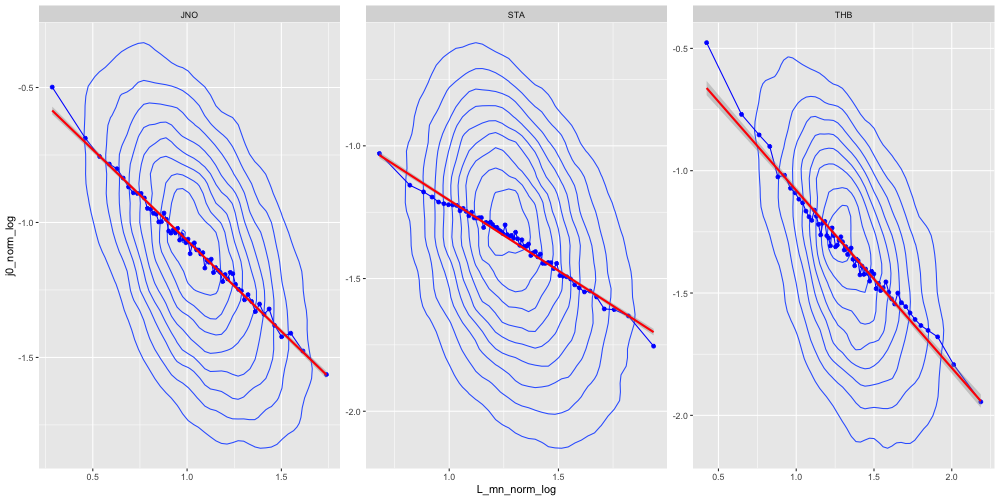

In [37]:
%%R -w 1000 -h 500
# Creating a list of layers for the binned data
# model <- lm(j0_norm_log ~ L_mn_norm_log, data = all_events_l1_L_binned)
# slope <- coef(model)[2]

binned_layer <- list(
  geom_line(data = all_events_l1_L_binned, color = 'blue'),
  geom_point(data = all_events_l1_L_binned, color = 'blue'), 
  geom_smooth(data = all_events_l1_L_binned, method = "glm", color = 'red')
)


# Plot creation
p <- ggplot(mapping = aes(x = L_mn_norm_log, y = j0_norm_log)) +
  geom_density_2d(data = all_events_l1) +
  # stat_density_2d(data = all_events_l1, aes(fill = after_stat(density)), geom = "raster", contour = FALSE) +
  binned_layer +
  facet_wrap(~ sat, scales = "free")

  
# Print the plot
print(p)


`geom_smooth()` using formula = 'y ~ x'
Error in `geom_smooth()`:
! Problem while computing stat.
ℹ Error occurred in the 4th layer.
Caused by error in `compute_layer()`:
! `stat_smooth()` requires the following missing aesthetics: x and y
Run `rlang::last_trace()` to see where the error occurred.

Error in geom_smooth(data = all_candidates_l1_L_binned, method = "glm",  : 
  
ℹ Error occurred in the 4th layer.
Caused by error in `compute_layer()`:
! `stat_smooth()` requires the following missing aesthetics: x and y


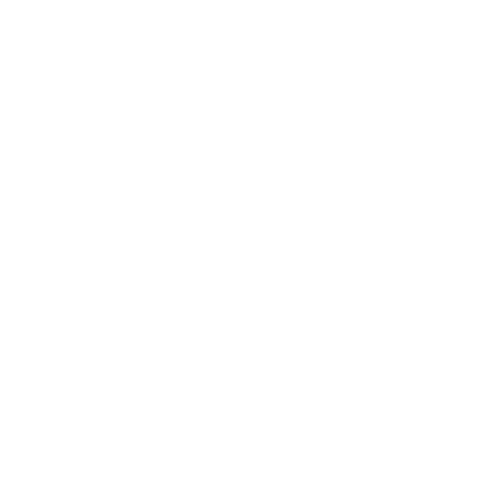

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:401 │
│ in eval                                                                                          │
│                                                                                                  │
│    398 │   │   │   try:                                                                          │
│    399 │   │   │   │   # Need the newline in case the last line in code is a comment.            │
│    400 │   │   │   │   r_expr = ri.parse(code)                                                   │
│ ❱  401 │   │   │   │   value, visible = ri.evalr_expr_with_visible(                              │
│    402 │   │   │   │   │   r_expr                                                                │
│    403 │   │   │   │   )                                                                         │
│    404 │   │   │   except (ri.embedded.RRuntimeError, ValueError) as exception:                  │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface.py:196 in  │
│ evalr_expr_with_visible                                                                          │
│                                                                                                  │
│    193 │   │   │   │   │   error_occured)                                                        │
│    194 │   │   )                                                                                 │
│    195 │   │   if error_occured[0]:                                                              │
│ ❱  196 │   │   │   raise embedded.RRuntimeError(_rinterface._geterrmessage())                    │
│    197 │   │   res = conversion._cdata_to_rinterface(r_res)                                      │
│    198 │   │   assert isinstance(res, ListSexpVector)                                            │
│    199 │   return res                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RRuntimeError: Error in geom_smooth(data = all_candidates_l1_L_binned, method = "glm",  : 
  
ℹ Error occurred in the 4th layer.
Caused by error in `compute_layer()`:
! `stat_smooth()` requires the following missing aesthetics: x and y


During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 get_ipython().run_cell_magic('R', '', 'p <- ggplot() +\n  geom_point(data = all_events_l     │
│   2                                                                                              │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/IPython/core/interactivesh │
│ ell.py:2493 in run_cell_magic                                                                    │
│                                                                                                  │
│   2490 │   │   │                                                                                 │
│   2491 │   │   │   with self.builtin_trap:                                                       │
│   2492 │   │   │   │   args = (magic_arg_s, cell)                                                │
│ ❱ 2493 │   │   │   │   result = fn(*args, **kwargs)                                              │
│   2494 │   │   │                                       

In [38]:
%%R
p <- ggplot() +
  geom_point(data = all_events_l1, aes(x = L_mn_norm_log, y = j0_norm_log)) +
  binned_layer +
  facet_wrap(~ sat, scales = "free")

print(p)


In addition: Warning messages:
1: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Removed 242 rows containing missing values (`geom_point()`). 


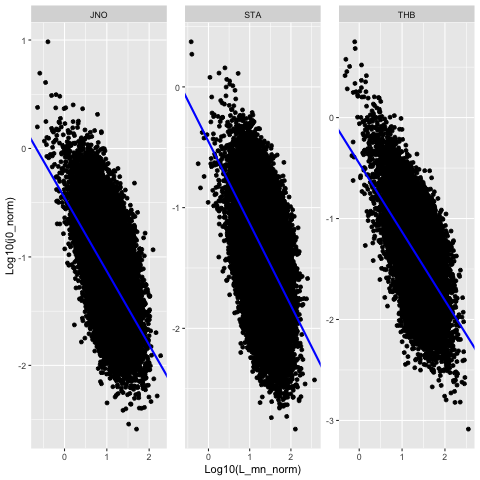

In [39]:
%%R
# Fit a linear model to the log-transformed data
lm_fit <- lm(j0_norm_log ~ L_mn_norm_log, data = all_events_l1)

# Extract the coefficients
intercept <- coef(lm_fit)[1]
slope <- coef(lm_fit)[2]

# Create a scatter plot with the log-log transformation
p <- ggplot(all_events_l1, aes(x = L_mn_norm_log, y = j0_norm_log)) +
  geom_point() + # Add the scatter points
  geom_abline(intercept = intercept, slope = slope, color = 'blue', size = 1) + # Add the fitted line
  facet_wrap(~ sat, scales = "free") + # Facet by 'sat'
  labs(x = "Log10(L_mn_norm)", y = "Log10(j0_norm)") # Label axes

print(p)

`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: Removed 2 rows containing non-finite values (`stat_smooth()`). 
2: Removed 2 rows containing non-finite values (`stat_regline_equation()`). 
3: Removed 1 row containing missing values (`geom_line()`). 
4: Removed 2 rows containing missing values (`geom_point()`). 


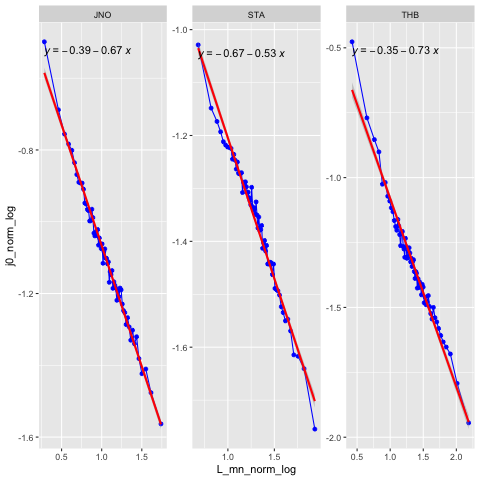

In [40]:
%%R
# Plot creation
p <- ggplot(all_events_l1_L_binned, aes(x = L_mn_norm_log, y = j0_norm_log)) +
    geom_line(color = 'blue') +
    geom_point(color = 'blue') +
    geom_smooth(method = "glm", color = 'red') +
    facet_wrap(~ sat, scales = "free") +
    stat_regline_equation()

  
# Print the plot
print(p)


`geom_smooth()` using formula = 'y ~ x'


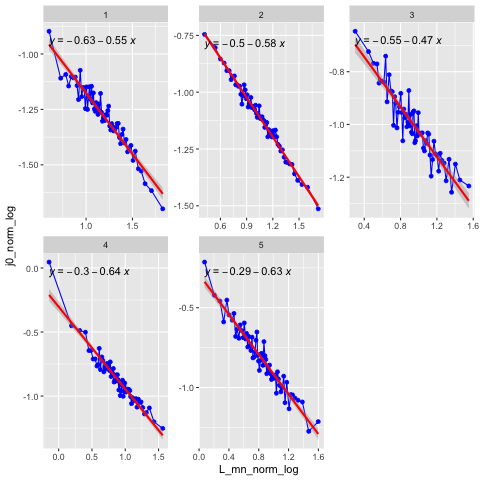

In [41]:
%%R -i jno_events_l1_L_binned -c conv_pl
# Plot creation
p <- ggplot(jno_events_l1_L_binned, aes(x = L_mn_norm_log, y = j0_norm_log)) +
    geom_line(color = 'blue') +
    geom_point(color = 'blue') +
    geom_smooth(method = "glm", color = 'red') +
    facet_wrap(~ r_bin, scales = "free") +
    stat_regline_equation()

  
# Print the plot
print(p)


In addition: Warning message:
The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


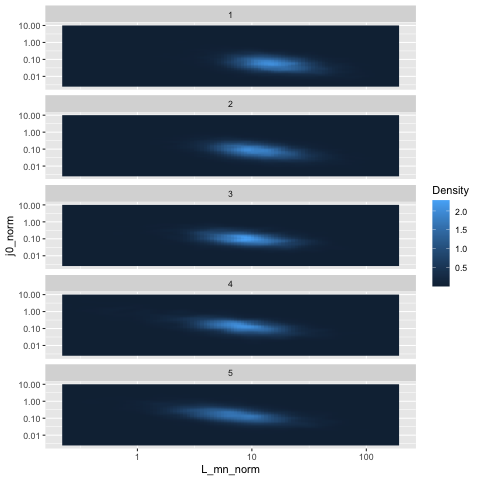

In [42]:
%%R -i jno_candidates_l1 -c conv_pl

p <- ggplot(jno_candidates_l1, aes(x = L_mn_norm, y = j0_norm)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
  facet_wrap(~ r_bin, nrow = length(unique(jno_candidates_l1$r_bin))) +
  scale_x_log10() + 
  scale_y_log10() +
  labs(fill = "Density")


print(p)
